# Minera Zyfra....... soluciones de eficiencia para la industria pesada.

# Tabla de contenido

* [Introducción](#introduccion)
* [1. Inicialización](#inicializacion)
    * [1.1 Revisión de datos ausentes y duplicados](#ausentes)
    * [1.2 Cálculo de recuperación](#recuperacion)
    * [1.3 Análisis de las características](#caracteristicas)
    * [1.4 Preprocesamiento de datos](#preprocesamiento)
    
* [2. Análisis de datos](#analisis)
    * [2.1 Concentración de metales](#concentracion)
    * [2.2 Distribuciones del tamaño de partículas](#distribucion)
    * [2.3 Concentración de metales](#concentracion)
* [3. Construcción del modelo](#modelo)
    * [3.1 Modelo Linear Regression](#lr)
    * [3.2 Modelo Random Forest Regressor](#rfr)
    * [3.3 Modelo Decision Tree Regressor](#dtr)
    
* [4. Conclusiones](#conclusiones)

<div id="introduccion"/>

# Introducción

La empresa Zyfra se encarga entre otras cosas de desarrollar soluciones de eficiencia para la industria pesada. 

El proceso tecnológico consta de una primera etapa de flotación que permite obtener el concentrado rougher, seguido de dos etapas de purificación, cuyo producto final es el concentrado final y las colas de rougher.

El objetivo de este proyecto es construir un modelo que prediga la cantidad de oro extraído del mineral de oro a fin de optimizar la producción y eliminar parámetros no rentables.

<div id="inicializacion"/>

## Inicialización


In [216]:
#Librerias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [97]:
#carga de datos
gold_data_train = pd.read_csv("/datasets/gold_recovery_train.csv")
gold_data_test = pd.read_csv("/datasets/gold_recovery_test.csv")
gold_data_full = pd.read_csv("/datasets/gold_recovery_full.csv")

In [98]:
#visualización de los datos e información
gold_data_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [99]:
gold_data_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [100]:
gold_data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [101]:
gold_data_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [102]:
gold_data_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [103]:
gold_data_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


<div id="ausentes"/>

### Revisión de datos ausentes y duplicados

In [104]:
gold_data_train.isna().sum()

date                                            0
final.output.concentrate_ag                    72
final.output.concentrate_pb                    72
final.output.concentrate_sol                  370
final.output.concentrate_au                    71
                                             ... 
secondary_cleaner.state.floatbank5_a_level     85
secondary_cleaner.state.floatbank5_b_air       85
secondary_cleaner.state.floatbank5_b_level     84
secondary_cleaner.state.floatbank6_a_air      103
secondary_cleaner.state.floatbank6_a_level     85
Length: 87, dtype: int64

In [105]:
gold_data_test.isna().sum()

date                                            0
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257


In [106]:
gold_data_full.isna().sum()

date                                            0
final.output.concentrate_ag                    89
final.output.concentrate_pb                    87
final.output.concentrate_sol                  385
final.output.concentrate_au                    86
                                             ... 
secondary_cleaner.state.floatbank5_a_level    101
secondary_cleaner.state.floatbank5_b_air      101
secondary_cleaner.state.floatbank5_b_level    100
secondary_cleaner.state.floatbank6_a_air      119
secondary_cleaner.state.floatbank6_a_level    101
Length: 87, dtype: int64

In [107]:
gold_data_train.duplicated().sum()

0

In [108]:
gold_data_test.duplicated().sum()

0

In [109]:
gold_data_full.duplicated().sum()

0

<div id="recuperacion"/>

### Cálculo de recuperación

In [110]:
#Cálculo de recuperación en datos de entrenamiento
C = gold_data_train["rougher.output.concentrate_au"]
F = gold_data_train["rougher.input.feed_au"]
T = gold_data_train["rougher.output.tail_au"]
rec=((C*(F-T)) / (F*(C-T)))*100

In [111]:
gold_data_train["recovery_calculated"] = ((C*(F-T)) / (F*(C-T)))*100

In [112]:
gold_data_train_sin_ausentes = gold_data_train.dropna()
mae = mean_absolute_error(gold_data_train_sin_ausentes["recovery_calculated"], gold_data_train_sin_ausentes["rougher.output.recovery"])
print("Error medio absoluto =", mae)

Error medio absoluto = 9.460144184559453e-15


In [113]:
gold_data_train["recovery_calculated"]

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
16855    89.574376
16856    87.724007
16857    88.890579
16858    89.858126
16859    89.514960
Name: recovery_calculated, Length: 16860, dtype: float64

In [114]:
resultados_recuperacion = pd.DataFrame(data=gold_data_train, columns=(["recovery_calculated", "rougher.output.recovery"]))

In [115]:
resultados_recuperacion.head()

,recovery_calculated,rougher.output.recovery
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794


Hasta ahorita se tienen 3 dataframe:

1. Entrenamiento, cuenta con 16860 registros, 87 columnas, de las cuales 86 contiene datos numéricos.
2. Test, cuenta con 5856 registros, 53 columnas, de las cuales 52 contiene datos numéricos.
3. Full, cuenta con 22716 registros, 87 columnas, de las cuales 86 contiene datos numéricos.
4. Los 3 dataframe presentan datos ausentes, algunos de los cuales serán revisados más adelante.
5. No hay datos duplicados
6. Se realizó el cálculo de la recuperación a través de ecuación y se determinó el error respecto al suministrado en el dataframe de entrenamiento, encontrándose que el error es mínimo, prácticamente 0, por lo que se comprueba que el cálculo de la recuperación es correcto.

<div id="caracteristicas"/>

### Analisis de las caracteristicas

In [116]:
#Revisión de las columnas que no están en test pero si en train
train_columnas = list(gold_data_train)
test_columnas = list(gold_data_test)

columnas_ausentes_test = []
for i in train_columnas:
    if i not in test_columnas:
        columnas_ausentes_test.append(i)
        
columnas_ausentes_test

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

Se observa que las características ausentes en el dataframe test, en su mayoría corresponden a parámetro tipo output en los 4 "stages" involucrados: rougher, primary, secondary y final. Estas características son numéricas. Adicionalmente para la etapa rougher se encontraron 4 columnas de cálculo que no aparecen en el dataset de test, por lo que se podría inferir que estas columnas faltantes no impactan los cálculos del modelo y más adelante serán eliminadas. Adicionalmente, se procederá a eliminar la columna "date" de los 3 dataframe.

<div id="preprocesamiento"/>

### Preprocesamiento de datos

In [117]:
def valores_ausentes(gold_data):
    porc=((gold_data.isna().sum())/(len(gold_data)))*100
    return porc.sort_values(ascending=False)
    

In [118]:
valores_ausentes(gold_data_train)

rougher.output.recovery                               15.260973
recovery_calculated                                   13.540925
rougher.output.tail_ag                                13.345196
rougher.output.tail_au                                13.339265
rougher.output.tail_sol                               13.339265
                                                        ...    
primary_cleaner.state.floatbank8_d_level               0.160142
rougher.calculation.sulfate_to_au_concentrate          0.160142
rougher.calculation.floatbank11_sulfate_to_au_feed     0.160142
primary_cleaner.input.feed_size                        0.000000
date                                                   0.000000
Length: 88, dtype: float64

In [119]:
valores_ausentes(gold_data_test)

rougher.input.floatbank11_xanthate            6.028005
primary_cleaner.input.sulfate                 5.157104
primary_cleaner.input.depressant              4.849727
rougher.input.floatbank10_sulfate             4.388661
primary_cleaner.input.xanthate                2.834699
rougher.input.floatbank10_xanthate            2.100410
rougher.input.feed_sol                        1.144126
rougher.input.floatbank11_sulfate             0.939208
rougher.input.feed_rate                       0.683060
secondary_cleaner.state.floatbank3_a_air      0.580601
secondary_cleaner.state.floatbank2_b_air      0.392760
rougher.input.feed_size                       0.375683
secondary_cleaner.state.floatbank2_a_air      0.341530
rougher.state.floatbank10_a_air               0.290301
rougher.state.floatbank10_c_air               0.290301
rougher.state.floatbank10_d_air               0.290301
rougher.state.floatbank10_e_air               0.290301
rougher.state.floatbank10_b_air               0.290301
rougher.st

In [120]:
valores_ausentes(gold_data_full)

rougher.output.recovery                     13.730410
rougher.output.tail_ag                      12.048776
rougher.output.tail_au                      12.044374
rougher.output.tail_sol                     12.044374
rougher.input.floatbank11_xanthate           9.935728
                                              ...    
primary_cleaner.state.floatbank8_b_level     0.189294
primary_cleaner.state.floatbank8_c_level     0.189294
primary_cleaner.state.floatbank8_d_level     0.189294
primary_cleaner.input.feed_size              0.000000
date                                         0.000000
Length: 87, dtype: float64

Se observa que el mayor porcentaje de datos ausentes en train y full es del 15% y 14% respectivamente, siendo test quien menor porcentaje muestra(6%). Por la cantidad de columnas que componen el DataFrame, sería muy tedioso hacer análisis de 1 en 1 buscando las métricas estadísticas para cada una y reemplazando según su relación. Se toma la decisión de hacer el llenado de las celdas con datos ausentes con el valor que tiene la celda anterior en lugar de reemplazar por ceros.

In [121]:
#funcion para imputar datos ausentes
def imput(gold_data):
    gold_data = gold_data.fillna(method="ffill", axis=0, inplace=True)

In [122]:
imput(gold_data_train)
imput(gold_data_test)
imput(gold_data_full)

In [123]:
valores_ausentes(gold_data_train)

date                                        0.0
final.output.concentrate_ag                 0.0
rougher.state.floatbank10_f_level           0.0
rougher.state.floatbank10_f_air             0.0
rougher.state.floatbank10_e_level           0.0
                                           ... 
primary_cleaner.state.floatbank8_c_level    0.0
primary_cleaner.state.floatbank8_c_air      0.0
primary_cleaner.state.floatbank8_b_level    0.0
primary_cleaner.state.floatbank8_b_air      0.0
recovery_calculated                         0.0
Length: 88, dtype: float64

In [124]:
valores_ausentes(gold_data_test)

date                                          0.0
rougher.state.floatbank10_c_air               0.0
rougher.state.floatbank10_d_air               0.0
rougher.state.floatbank10_d_level             0.0
rougher.state.floatbank10_e_air               0.0
rougher.state.floatbank10_e_level             0.0
rougher.state.floatbank10_f_air               0.0
rougher.state.floatbank10_f_level             0.0
secondary_cleaner.state.floatbank2_a_air      0.0
secondary_cleaner.state.floatbank2_a_level    0.0
secondary_cleaner.state.floatbank2_b_air      0.0
secondary_cleaner.state.floatbank2_b_level    0.0
secondary_cleaner.state.floatbank3_a_air      0.0
secondary_cleaner.state.floatbank3_a_level    0.0
secondary_cleaner.state.floatbank3_b_air      0.0
secondary_cleaner.state.floatbank3_b_level    0.0
secondary_cleaner.state.floatbank4_a_air      0.0
secondary_cleaner.state.floatbank4_a_level    0.0
secondary_cleaner.state.floatbank4_b_air      0.0
secondary_cleaner.state.floatbank4_b_level    0.0


In [125]:
valores_ausentes(gold_data_full)

date                                          0.0
rougher.state.floatbank10_b_air               0.0
rougher.state.floatbank10_f_air               0.0
rougher.state.floatbank10_e_level             0.0
rougher.state.floatbank10_e_air               0.0
                                             ... 
primary_cleaner.state.floatbank8_c_level      0.0
primary_cleaner.state.floatbank8_c_air        0.0
primary_cleaner.state.floatbank8_b_level      0.0
primary_cleaner.state.floatbank8_b_air        0.0
secondary_cleaner.state.floatbank6_a_level    0.0
Length: 87, dtype: float64

In [126]:
# conversion de date a date
gold_data_train["date"] = pd.to_datetime(gold_data_train["date"], format="%Y-%m-%d %H:%M:%S")
gold_data_test["date"] = pd.to_datetime(gold_data_test["date"], format="%Y-%m-%d %H:%M:%S")
gold_data_full["date"] = pd.to_datetime(gold_data_full["date"], format="%Y-%m-%d %H:%M:%S")

In [127]:
#separación del target de las columnas a ser eliminadas en train
columnas_ausentes_train = []
for i in columnas_ausentes_test:
    if i != "rougher.output.recovery":
        if i != "final.output.recovery":
            columnas_ausentes_train.append(i)

In [128]:
columnas_ausentes_train

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'rougher.output.tail_au',
 'secondary_cleane

In [129]:
gold_data_train_1 = gold_data_train.drop(columnas_ausentes_train, axis=1)

In [130]:
gold_data_train_1.shape

(16860, 55)

In [131]:
#seleccionar de full las columnas target y date para unir con test
gold_data_full_ref = gold_data_full[["date", "rougher.output.recovery", "final.output.recovery"]]

In [132]:
#agregar las columnas de target a test
gold_data_test_1 = gold_data_test.merge(gold_data_full_ref, on="date", how="left")

In [133]:
gold_data_test_1.shape

(5856, 55)

In [134]:
#eliminar date de las tablas
gold_data_train.drop("date", axis=1, inplace=True)
gold_data_test.drop("date", axis=1, inplace=True)
gold_data_full.drop("date", axis=1, inplace=True)
gold_data_train_1.drop("date", axis=1, inplace=True)
gold_data_test_1.drop("date", axis=1, inplace=True)

<div id="analisis"/>

## Análisis de datos

<div id="concentracion"/>

### Concentración de metales

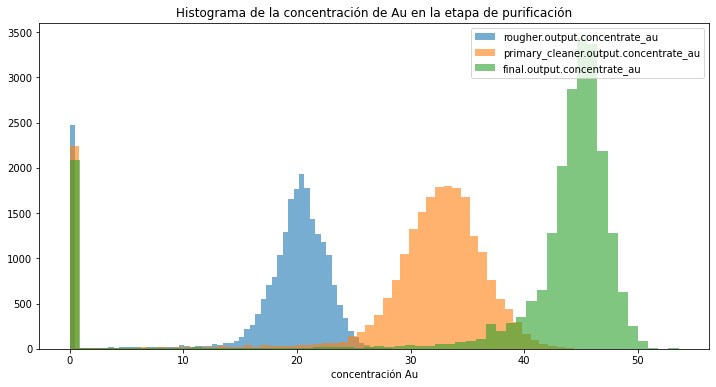

In [135]:
columnas_au = ["rougher.output.concentrate_au", "primary_cleaner.output.concentrate_au","final.output.concentrate_au"]
plt.figure(figsize=(12,6))
for i in columnas_au:
    plt.hist(gold_data_full[i], bins=60, alpha=0.6, label= i)
    plt.legend(loc="upper right")
    plt.title("Histograma de la concentración de Au en la etapa de purificación")
    plt.xlabel("concentración Au")   

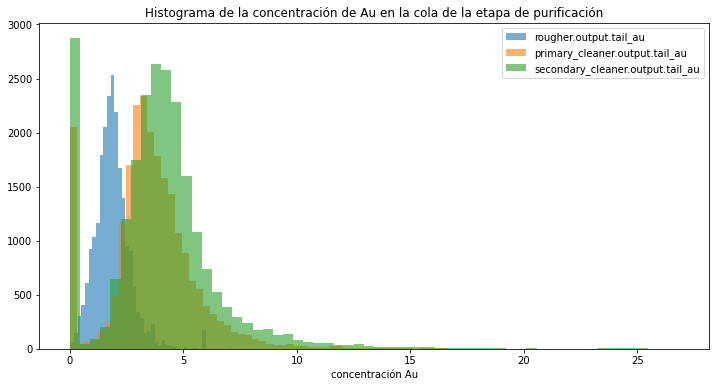

In [136]:
columnas_au_cola = ["rougher.output.tail_au", "primary_cleaner.output.tail_au","secondary_cleaner.output.tail_au"]
plt.figure(figsize=(12,6))
for i in columnas_au_cola:
    
    plt.hist(gold_data_full[i], bins=60, alpha=0.6, label= i)
    plt.legend(loc="upper right")
    plt.title("Histograma de la concentración de Au en la cola de la etapa de purificación")
    plt.xlabel("concentración Au")   

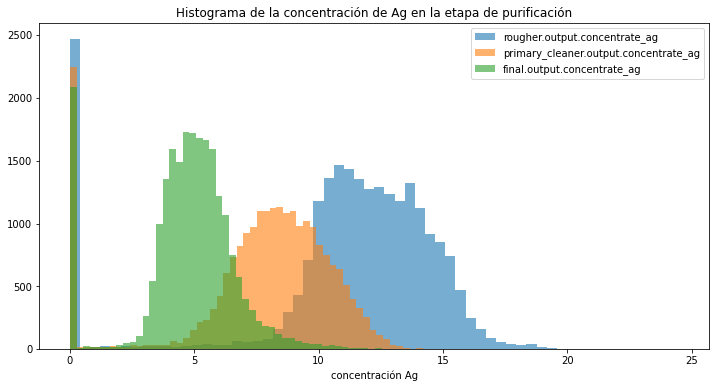

In [137]:
columnas_ag = ["rougher.output.concentrate_ag", "primary_cleaner.output.concentrate_ag","final.output.concentrate_ag"]
plt.figure(figsize=(12,6))
for i in columnas_ag:
    plt.hist(gold_data_full[i], bins=60, alpha=0.6, label= i)
    plt.legend(loc="upper right")
    plt.title("Histograma de la concentración de Ag en la etapa de purificación")
    plt.xlabel("concentración Ag")   

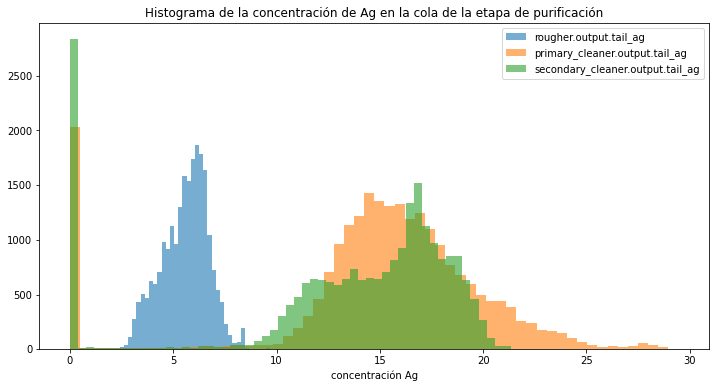

In [138]:
columnas_ag_cola = ["rougher.output.tail_ag", "primary_cleaner.output.tail_ag","secondary_cleaner.output.tail_ag"]
plt.figure(figsize=(12,6))
for i in columnas_ag_cola:
    
    plt.hist(gold_data_full[i], bins=60, alpha=0.6, label= i)
    plt.legend(loc="upper right")
    plt.title("Histograma de la concentración de Ag en la cola de la etapa de purificación")
    plt.xlabel("concentración Ag")   

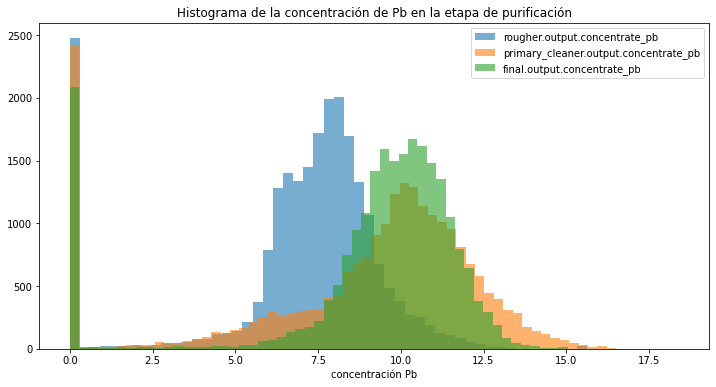

In [139]:
columnas_pb = ["rougher.output.concentrate_pb", "primary_cleaner.output.concentrate_pb","final.output.concentrate_pb"]
plt.figure(figsize=(12,6))
for i in columnas_pb:
    plt.hist(gold_data_full[i], bins=60, alpha=0.6, label= i)
    plt.legend(loc="upper right")
    plt.title("Histograma de la concentración de Pb en la etapa de purificación")
    plt.xlabel("concentración Pb")

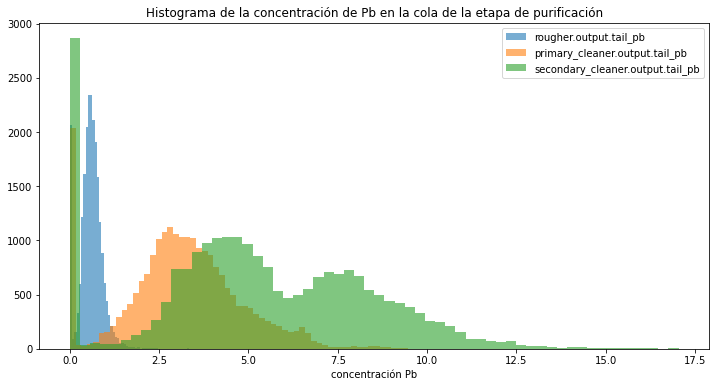

In [140]:
columnas_pb_cola = ["rougher.output.tail_pb", "primary_cleaner.output.tail_pb","secondary_cleaner.output.tail_pb"]
plt.figure(figsize=(12,6))
for i in columnas_pb_cola:
    
    plt.hist(gold_data_full[i], bins=60, alpha=0.6, label= i)
    plt.legend(loc="upper right")
    plt.title("Histograma de la concentración de Pb en la cola de la etapa de purificación")
    plt.xlabel("concentración Pb")   

In [141]:
resultados_purificacion = pd.DataFrame({
    "Metal": ["Au (oro)", "Ag (plata)", "Pb (plomo)"],
    "Concentración_media_entrada_primary_cleaner": [gold_data_full["rougher.output.concentrate_au"].mean() , gold_data_full["rougher.output.concentrate_ag"].mean(), gold_data_full["rougher.output.concentrate_pb"].mean()],
    "Concentración_media_entrada_secondary_cleaner": [gold_data_full["primary_cleaner.output.concentrate_au"].mean() , gold_data_full["primary_cleaner.output.concentrate_ag"].mean(), gold_data_full["primary_cleaner.output.concentrate_pb"].mean()],
    "Concentración_media_concentrado_final":[gold_data_full["final.output.concentrate_au"].mean() , gold_data_full["final.output.concentrate_ag"].mean(), gold_data_full["final.output.concentrate_pb"].mean()], 
    
})
resultados_purificacion

,Metal,Concentración_media_entrada_primary_cleaner,Concentración_media_entrada_secondary_cleaner,Concentración_media_concentrado_final
0,Au (oro),17.831509,29.119967,39.891718
1,Ag (plata),10.845609,7.666972,4.768013
2,Pb (plomo),6.886869,8.809217,9.071366


In [142]:
resultados_cola = pd.DataFrame({
    "Metal": ["Au (oro)", "Ag (plata)", "Pb(plomo)"],
    "Concentración_media_salida_cola_flotacion": [gold_data_full["rougher.output.tail_au"].mean() , gold_data_full["rougher.output.tail_ag"].mean(), gold_data_full["rougher.output.tail_pb"].mean()],
    "Concentración_media_salida_cola_primary_cleaner": [gold_data_full["primary_cleaner.output.tail_au"].mean() , gold_data_full["primary_cleaner.output.tail_ag"].mean(), gold_data_full["primary_cleaner.output.tail_pb"].mean()],
    "Concentración_media_salida_cola_secondary_cleaner":[gold_data_full["secondary_cleaner.output.tail_au"].mean() , gold_data_full["secondary_cleaner.output.tail_ag"].mean(), gold_data_full["secondary_cleaner.output.tail_pb"].mean()], 
    
})
resultados_cola

,Metal,Concentración_media_salida_cola_flotacion,Concentración_media_salida_cola_primary_cleaner,Concentración_media_salida_cola_secondary_cleaner
0,Au (oro),1.885801,3.661643,4.028730
1,Ag (plata),5.599333,14.839512,13.340497
2,Pb(plomo),0.592316,3.166596,5.290365


In [143]:
resultados_purificacion = pd.DataFrame({
    "Metal": ["Au (oro)", "Ag (plata)", "Pb (plomo)"],
    "Concentración_media_entrada_primary_cleaner": [gold_data_full["rougher.output.concentrate_au"].mean() , gold_data_full["rougher.output.concentrate_ag"].mean(), gold_data_full["rougher.output.concentrate_pb"].mean()],
    "Concentración_media_entrada_secondary_cleaner": [gold_data_full["primary_cleaner.output.concentrate_au"].mean() , gold_data_full["primary_cleaner.output.concentrate_ag"].mean(), gold_data_full["primary_cleaner.output.concentrate_pb"].mean()],
    "Concentración_media_concentrado_final":[gold_data_full["final.output.concentrate_au"].mean() , gold_data_full["final.output.concentrate_ag"].mean(), gold_data_full["final.output.concentrate_pb"].mean()], 
    
})
resultados_purificacion

,Metal,Concentración_media_entrada_primary_cleaner,Concentración_media_entrada_secondary_cleaner,Concentración_media_concentrado_final
0,Au (oro),17.831509,29.119967,39.891718
1,Ag (plata),10.845609,7.666972,4.768013
2,Pb (plomo),6.886869,8.809217,9.071366


In [144]:
def resultados_purificacion_describe(gold_data, col1, col2, col3):
    au = gold_data[col1].describe()
    ag = gold_data[col2].describe()
    pb = gold_data[col3].describe()
    tabla = pd.concat([au, ag, pb], axis=1) 
    return tabla


In [145]:
resultados_purificacion_describe(gold_data_full,"rougher.output.concentrate_au", "rougher.output.concentrate_ag", "rougher.output.concentrate_pb")


,rougher.output.concentrate_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb
count,22716.000000,22716.000000,22716.000000
mean,17.831509,10.845609,6.886869
std,6.842737,4.406924,2.831347
min,0.000000,0.000000,0.000000
25%,17.894015,10.112351,6.366740
50%,19.995513,11.774115,7.570890
75%,21.562366,13.609712,8.477617
max,28.824507,24.480271,18.394042


In [146]:
resultados_purificacion_describe(gold_data_full,"primary_cleaner.output.concentrate_au", "primary_cleaner.output.concentrate_ag", "primary_cleaner.output.concentrate_pb")


,primary_cleaner.output.concentrate_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb
count,22716.000000,22716.000000,22716.000000
mean,29.119967,7.666972,8.809217
std,10.650273,3.134033,3.798169
min,0.000000,0.000000,0.000000
25%,29.336078,6.756639,7.649745
50%,32.345542,8.256062,9.882876
75%,34.762169,9.690952,11.234420
max,45.933934,16.081632,17.081278


In [147]:
resultados_purificacion_describe(gold_data_full,"final.output.concentrate_au", "final.output.concentrate_ag", "final.output.concentrate_pb")


,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb
count,22716.000000,22716.000000,22716.000000
mean,39.891718,4.768013,9.071366
std,13.540157,2.042594,3.260960
min,0.000000,0.000000,0.000000
25%,42.353890,4.011471,8.737809
50%,44.639019,4.949959,9.910363
75%,46.106662,5.857985,10.927188
max,53.611374,16.001945,17.031899


In [148]:
au_cero=gold_data_full[gold_data_full["rougher.output.concentrate_au"]==0]
au_cero

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
45,4.566664,10.406178,4.588698,46.614456,68.403877,10.705777,1.509070,17.875134,2.509776,131.251366,...,14.025588,-550.404242,12.028925,-550.570104,10.052072,-500.797905,7.984500,-499.581046,11.982025,-599.161228
46,4.577832,10.691605,5.274175,46.250638,70.675633,10.728531,1.641216,18.349339,2.540843,141.184039,...,14.094808,-550.676337,12.004728,-550.496522,9.953139,-500.330920,8.012074,-500.133530,11.975316,-598.839683
47,4.591462,10.628846,5.688961,46.663335,55.088448,10.694584,1.671644,17.910312,2.686782,126.397495,...,13.997488,-551.224653,11.971272,-550.095619,9.981163,-502.869109,7.941184,-500.623610,12.018837,-600.916665
48,5.296830,10.597469,5.688961,44.015642,41.962008,11.975654,1.846558,8.138408,2.889469,69.411904,...,14.006476,-549.388727,11.975967,-550.778624,9.989726,-499.607365,7.958252,-498.882560,11.967977,-599.440603
49,7.256114,9.017677,5.688961,43.389252,41.962008,12.100582,1.758360,4.606019,3.202483,48.760868,...,14.032364,-549.326033,11.987133,-549.583570,10.094584,-492.041563,8.054770,-498.802262,11.961330,-597.272218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18216,4.909904,9.941006,8.191698,47.660737,83.597741,8.853800,0.717677,13.399798,1.515512,140.156548,...,19.999169,-502.266441,14.943901,-500.386063,10.998883,-499.846204,8.972741,-500.118532,10.966205,-500.707126
18217,4.797572,9.889303,8.326773,47.801056,84.738648,8.503813,0.757507,13.591903,1.573222,146.528194,...,19.961164,-499.274851,14.950879,-499.891798,11.010768,-494.562898,9.028307,-499.007596,10.978016,-497.924873
18218,4.329492,9.413122,8.173988,49.412576,73.519948,8.846540,1.479231,13.094763,2.760905,157.102305,...,20.013736,-499.502171,14.957857,-499.873967,11.034954,-493.250025,9.029441,-480.953533,11.021042,-499.685577
18219,4.317169,9.642271,8.396492,48.839994,78.415342,8.485093,1.155559,13.380461,2.198065,156.601307,...,20.013476,-500.511253,14.964835,-500.084773,10.972473,-511.806312,8.991251,-500.706169,10.990072,-499.775802


1. El mineral de oro (Au) es el elemento principal a purificar y eso se evidencia en la gráfica de concentración por etapas de purificación, observándose que a medida que avanza en el proceso, la concentración se incrementa, sin embargo, es de notar que en la cola también sucede eso, en menor escala, pero igual la concentración está aumentando.
2. El mineral de plata sigue un comportamiento un poco diferente, ya que su concentración media disminuye a medida que pasa por las etapas de purificación, por lo que se infiere y se corrobora que debe estar aumentando en el producto de cola de salida de cada etapa, hay una buena separación.
3. El plomo sigue un comportamiento similar al oro, es decir, aumenta su concentración media a medida que es purificado y también su concentración media se incrementa en la salida de cola de cada etapa.
4. Los 3 histogramas para las etapas de purificación muestran comportamientos similares a una distribución normal con asimetría negativa ya que la media está por debajo de la mediana y se corrobora con los datos reportados con alta frecuencia en valores alrededor de cero. Estos valores de "0" resultan un poco atípicos, ya que indicaría que las muestras de minerales no traen nada de esos elementos, sin embargo, aparecen en las otras etapas.
5. Los histogramas para la salida de los tres elementos, en cada etapa del proceso, como producto de cola difiere de un comportamiento normal.

<div id="distribucion"/>

### Distribuciones del tamaño de partículas

Text(0.5, 0, 'tamaño de partícula')

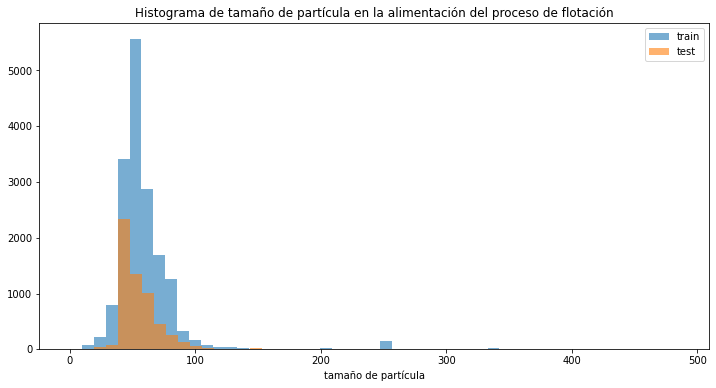

In [149]:
#distribución de tamaño de partpiculas en la alimentación de flotación
plt.figure(figsize=(12,6))
plt.hist(gold_data_train_1["rougher.input.feed_size"], bins=50, alpha=0.6, label="train")
plt.hist(gold_data_test_1["rougher.input.feed_size"], bins=50, alpha=0.6, label="test")

plt.legend(loc="upper right")
plt.title("Histograma de tamaño de partícula en la alimentación del proceso de flotación")
plt.xlabel("tamaño de partícula")   


Text(0.5, 0, 'tamaño de partícula')

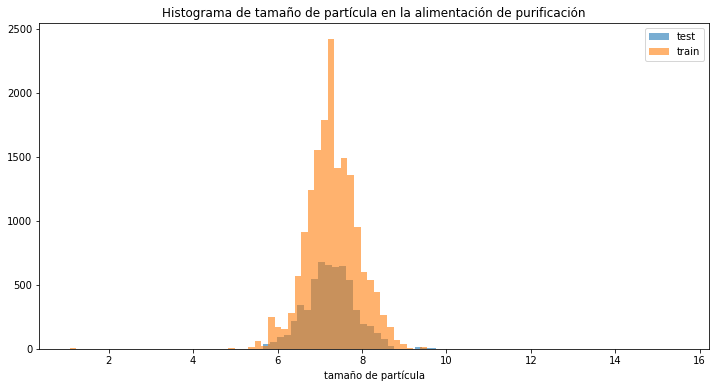

In [150]:
#distribución de tamaño de partpiculas en la alimentación de proceso de purificación
plt.figure(figsize=(12,6))

plt.hist(gold_data_test_1["primary_cleaner.input.feed_size"], bins=60, alpha=0.6, label="test")
plt.hist(gold_data_train_1["primary_cleaner.input.feed_size"], bins=60, alpha=0.6, label="train")
plt.legend(loc="upper right")
plt.title("Histograma de tamaño de partícula en la alimentación de purificación")
plt.xlabel("tamaño de partícula")   


In [151]:
resultados_particula_size = pd.DataFrame({
    "proceso": ["train", "test"],
    "alimentación_a_flotación": [gold_data_train_1["rougher.input.feed_size"].mean(), gold_data_test_1["rougher.input.feed_size"].mean()],
    "alimentación_a_purificación": [gold_data_train_1["primary_cleaner.input.feed_size"].mean(), gold_data_test_1["primary_cleaner.input.feed_size"].mean()],
    
})
resultados_particula_size

,proceso,alimentación_a_flotación,alimentación_a_purificación
0,train,60.188595,7.297285
1,test,55.898866,7.264651


De los histogramas de distribución del tamaño de partículas se concluye:
1. En el proceso de alimentación a flotación el tamaño medio de las partículas en la alimentación está entre 56 y 60, valores muy cercanos entre sí.
2. En el proceso de purificación el tamaño promedio es de 7.2, menor a la muestra ingresada al proceso de flotación, lo cual es como se esperaba, puesto que en el proceso de purificación se debe ir disminuyendo el tamaño del "grano" para poder separar los componentes o metales presentes, hasta llegar al oro.
3. La diferencia observada en los histogramas es en la frecuencia y eso se debe al tamaño de la muestra, el dataset para entrenamiento es 3 veces más grande que el dataset de prueba.
4. Se concluye que el rango de valores para el tamaño de partícula en la entrada de los 2 procesos es igual tanto en el conjunto de datos de entrenamiento como en el conjunto de datos para prueba.

<div id="concentracion"/>

### Concentración de las sustancias en las diferentes etapas

In [152]:
#cálculo de la concentración por etapas
gold_data_full["input_rougher"] = gold_data_full["rougher.input.feed_au"] + gold_data_full["rougher.input.feed_ag"] + gold_data_full["rougher.input.feed_pb"] + gold_data_full["rougher.input.feed_sol"]
gold_data_full["input_primary"] = gold_data_full["rougher.output.concentrate_au"] + gold_data_full["rougher.output.concentrate_ag"] + gold_data_full["rougher.output.concentrate_pb"] +  gold_data_full["rougher.output.concentrate_sol"]
gold_data_full["output"] = gold_data_full["final.output.concentrate_au"] + gold_data_full["final.output.concentrate_ag"] + gold_data_full["final.output.concentrate_pb"] + gold_data_full["final.output.concentrate_sol"]

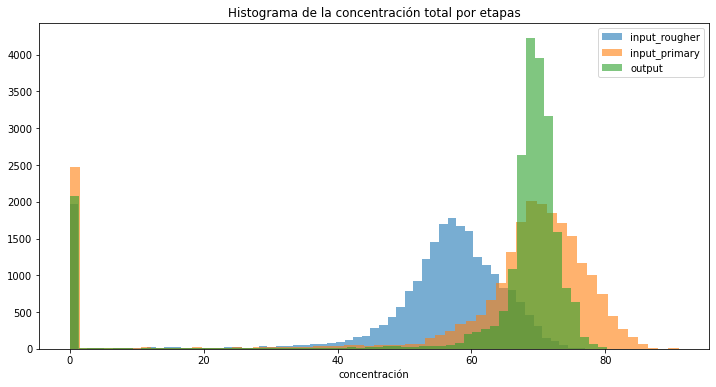

In [153]:
columnas_plt_totales = ["input_rougher","input_primary", "output"]
plt.figure(figsize=(12,6))
for i in columnas_plt_totales:
    
    plt.hist(gold_data_full[i], bins=60, alpha=0.6, label= i)
    plt.legend(loc="upper right")
    plt.title("Histograma de la concentración total por etapas")
    plt.xlabel("concentración")

De los histogramas se concluye:

1. La concentración de las sustancias desde la alimentación hasta la etapa final se incrementa.
2. Hay datos que resultan anómalos alrededor de "0" o menor a 10, por lo que serán eliminados de la data.


In [154]:
for i in columnas_plt_totales:
    gold_data_train_1.drop(gold_data_full[gold_data_full[i] <= 10].index, axis='index', errors='ignore', inplace=True)
    gold_data_test_1.drop(gold_data_full[gold_data_full[i] <= 10].index, axis='index', errors='ignore', inplace=True)

In [155]:
gold_data_train_1.shape

(14965, 54)

In [156]:
gold_data_test_1.shape

(5142, 54)

<div id="modelo"/>

## Construcción del modelo

In [208]:
def smape(target_s, prediction_s):
    numerador_deno = (2*np.abs(target_s - prediction_s))/(np.abs(target_s) + np.abs(prediction_s))
    smape = numerador_deno.mean()
    return smape

def smape_final(target_s, prediction_s):
    smape_rougher = smape(target_s[:,0], prediction_s[:,0])
    smape_final = smape(target_s[:,1], prediction_s[:,1])
    smape_out = (0.25 * smape_rougher) + (0.75 * smape_final)
    return smape_out

smape_score = make_scorer(smape_final, greater_is_better=False)

In [176]:
features_train = gold_data_train_1.drop(["rougher.output.recovery", "final.output.recovery"], axis=1)
features_test = gold_data_test_1.drop(["rougher.output.recovery", "final.output.recovery"], axis=1)
target_train = gold_data_train_1[["rougher.output.recovery", "final.output.recovery"]]
target_test = gold_data_test_1[["rougher.output.recovery", "final.output.recovery"]]

In [177]:
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(14965, 52) (5142, 52) (14965, 2) (5142, 2)


In [203]:
#scaler de características
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test  = scaler.transform(features_test)
target_train = target_train.values
target_test = target_test.values

<div id="lr"/>

### Modelo Linear Regression

In [222]:
#modelo de regresion lineal
model_lr = LinearRegression()
fit_lr = model_lr.fit(features_train, target_train)
predictions_lr = fit_lr.predict(features_test)

#validacion cruzada
scores_lr = cross_val_score(fit_lr, features_train, target_train, cv=5, scoring=smape_score)

print("sMAPE=", scores_lr.mean())
print("sMAPE final=", smape_final(target_test, predictions_lr))

sMAPE= -0.15766884976725112
sMAPE final= 0.12665997256492378


<div id="rfr"/>

### Modelo Random Forest Regressor

In [225]:
params = {'min_samples_split': range(2, 6, 2)}
rf_cv = GridSearchCV(RandomForestRegressor(random_state=12345), param_grid=params, scoring=smape_score, cv=5, refit=True)
rf_cv.fit(features_train, target_train)
best_params = rf_cv.best_params_

model_rfr = RandomForestRegressor(**best_params).fit(features_train, target_train)
predictions_rfr = model_rfr.predict(features_test)
#validación cruzada:
scores_rfr = cross_val_score(model_rfr, features_train, target_train, cv=5, scoring=smape_score)

print("sMAPE=", scores_rfr.mean())
print("sMAPE final=", smape_final(target_test, predictions_rfr))

sMAPE= -0.13588436099689222
sMAPE final= 0.12488148855950731


<div id="dtr"/>

### Modelo Decision Tree Regressor

In [220]:
#Decision tree regressor
params = {"min_samples_split": range(2, 10, 2), "max_depth": range(4,8,2)}
dtr = GridSearchCV(DecisionTreeRegressor(random_state=12345), param_grid=params,scoring=smape_score, cv=5, refit=True)
dtr.fit(features_train, target_train)
best_params = dtr.best_params_

model_dtr = DecisionTreeRegressor(**best_params).fit(features_train, target_train)
predictions_dtr = model_dtr.predict(features_test)
#validación cruzada:
scores_dtr = cross_val_score(model_dtr, features_train, target_train, cv=5, scoring=smape_score)
print("sMAPE=", scores_dtr.mean())
print("sMAPE final=", smape_final(target_test, predictions_dtr ))

sMAPE= -0.13826784505754447
sMAPE final= 0.11752935013917916


In [224]:
resultados_modelos = pd.DataFrame({
    "Modelo": ["Linear Regression", "Random Forest Regressor", "Decision Tree Regressor"],
    "sMAPE": [scores_lr.mean(), scores_rfr.mean(), scores_dtr.mean()],
    "sMAPE_final": [smape_final(target_test, predictions_lr), smape_final(target_test, predictions_rfr), smape_final(target_test, predictions_dtr) ],
    
})
resultados_modelos

,Modelo,sMAPE,sMAPE_final
0,Linear Regression,-0.157669,0.126660
1,Random Forest Regressor,-0.136442,0.126660
2,Decision Tree Regressor,-0.138268,0.117529


De los 3 modelos analizados se concluye:

El modelo Random Forest Regressor es el que mejor reproduce los resultados para la recuperación, aunque seguido muy de cerca por el modelo Decision Tree Regressor.

<div id="conclusiones"/>

## Conclusiones


De los datos entregados por Zyfra se concluye:

1. Fueron 3 DataFrame: train, test, full, los cuales contenían 16860, 5856, 22716 registros con 87, 53 y 87 columnas respectivamente.
2. Se detectaron datos ausentes en la mayoría de las columnas.
3. No hay datos duplicados.
4. El dataset train representa el 74% de los datos.
5. Se rellenaron los datos ausentes con el método ffill.
6. Solo la columna "date" presente en los 3 dataframe es de tipo object, todas las demás columnas son numéricas.
7. El DataFrame "test" tiene 34 columnas menos que "train" y "full", en su mayoria fueron las de salida "output" en los procesos de primary_cleaner, secondary_cleaner y final. Se procedió a eliminar de train estas columnas y se agregó en "test" las 2 columnas objetivos.
8. El cálculo de recuperación coincide con el valor reportado (error mínimo) por lo que se comprueba este valor.
9. La concentración del Oro, incrementa desde la entrada a la etapa de flotación hasta que se extrae en el concentrado final, caso contrario sucede con el plomo y la plata.
10. El tamaño de las partículas en la alimentación coincide tanto en el dataset de train como de test.
11. El tamaño de las partículas en la alimentación de la etapa de purificación coincide tanto en el dataset de train como de test.
12. Se observaron datos anómalos que fueron eliminados.
8. El modelo Random Forest Regressor fue el que menor valor de sMAPE arrojó, por lo que se recomienda emplear este modelo para predecir la recuperación de oro y optimizar el proceso.
